# Stroke Prediction: Identifying Higher Risk Individuals


Strokes can cause severe disability or death, but many cases are preventable with early action. Identifying who is at higher risk makes it possible to encourage lifestyle changes, closer monitoring, and timely medical care that could save lives.

This dataset includes health and demographic information for over five thousand people, a small fraction of whom have had a stroke. By analyzing these variables, I aim to uncover patterns linked to stroke and build models that can flag individuals who may need further screening.

This dataset includes:
- Demographics (age, gender, residence type, work type)
- Medical history (hypertension, heart disease)
- Lifestyle indicators (smoking status, average glucose, BMI)
- Target variable: whether the person has had a stroke

I start by checking the structure of the dataset to confirm it loaded correctly and to get a sense of the available information.

I predict stroke risk from simple health and demographic data. I keep the workflow short and readable so a reviewer can follow it in a few minutes.

**Goal:** predict which people are more likely to have a stroke.

**Why it matters:** even small gains in recall can help flag people for earlier screening.

**Data prep (kept simple):**
- Encoded categorical features.
- Handled missing BMI with an indicator column.
- Train and test split with stratification.

**Models I tried:** Logistic Regression, Decision Tree, Random Forest, XGBoost. I keep Random Forest as the final model.

**Key results (from my best run):**
- Cross validation: F1 about 0.96, ROC AUC about 0.99.
- Test set: accuracy about 0.92, recall for stroke about 0.16. I also tried threshold tuning to trade some precision for better recall.

**What drives predictions:** age is strongest. Other useful factors include work type, residence type, BMI, heart disease, and glucose level.

**Limitation:** the target is very imbalanced which makes recall harder.

In [1]:
# Import key libraries for data analysis, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, average_precision_score, precision_recall_fscore_support
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Oversampling for imbalanced data
from imblearn.over_sampling import SMOTE

# Gradient boosting model
from xgboost import XGBClassifier

# Pipeline for combining steps
from imblearn.pipeline import Pipeline
# Stratified K-Fold cross-validation
from sklearn.model_selection import StratifiedKFold

In [2]:
# Load dataset
df = pd.read_csv('C:/Users/joeyc/data/datasets/healthcare-dataset-stroke-data.csv')

# Initial data exploration
display(df.head())
df.info()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Drop ID column (not useful for modeling)
df = df.drop(columns=["id"])

### Feature descriptions
Here is what each column represents so the analysis stays clear.

- gender: gender of the individual.
- age: age in years.
- hypertension: 1 if the person has hypertension, 0 otherwise.
- heart_disease: 1 if the person has heart disease, 0 otherwise.
- ever_married: marital status (Yes or No).
- work_type: employment type (Private, Self-employed, Govt_job, children, Never_worked).
- Residence_type: Urban or Rural.
- avg_glucose_level: average blood glucose level.
- bmi: body mass index.
- smoking_status: smoking history (formerly smoked, never smoked, smokes, or unknown).
- stroke: target variable, 1 if the person has had a stroke, 0 otherwise.


## Understanding class balance

Before building models, I check how the target variable (`stroke`) is distributed. If one class is much larger, a model might appear accurate while missing most positive cases. Knowing this balance helps me choose the right evaluation metrics and plan how to address imbalance later.


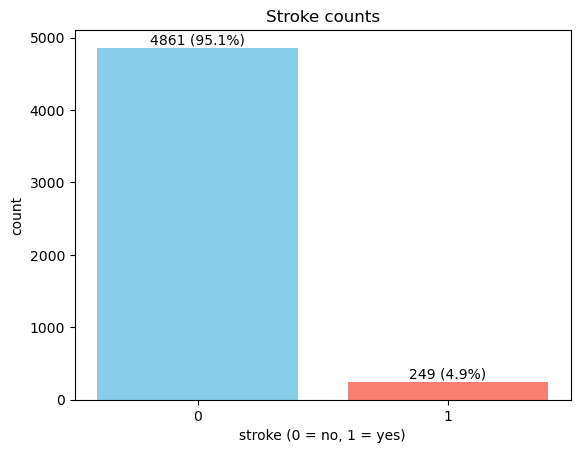

In [4]:
# Check class balance
class_counts = df["stroke"].value_counts().sort_index()
class_props = df["stroke"].value_counts(normalize=True).sort_index()

# Bar chart of class distribution
plt.bar(class_counts.index.astype(str), class_counts.values, color=["skyblue", "salmon"])

# Add labels on top of bars
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 50, f"{count} ({class_props.values[i]:.1%})", ha="center")

plt.xlabel("stroke (0 = no, 1 = yes)")
plt.ylabel("count")
plt.title("Stroke counts")
plt.show()

The chart confirms that the data is highly imbalanced: about 95% of people have not had a stroke, and only around 5% have. This matches real-world patterns, where strokes are rare but serious. In modeling, this imbalance means a model could reach over 90% accuracy by predicting "no stroke" for everyone, but it would fail to identify those most at risk. In healthcare, missing these cases can have serious consequences, so I will address the imbalance later to improve recall without losing too much precision.


## Missing values in healthcare data

Missing values are common in health records. I check which features have gaps so I can decide how to handle them before modeling.

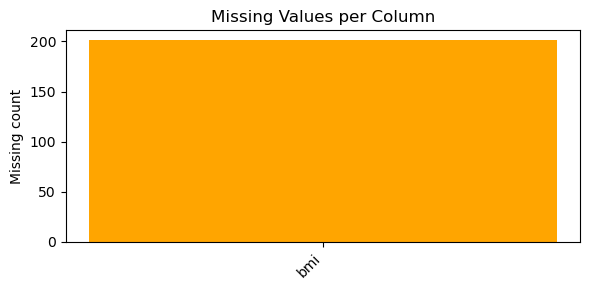

bmi    201
dtype: int64

In [5]:
# Check and visualize missing values
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts = na_counts[na_counts > 0]  # show only columns with missing values

plt.figure(figsize=(6,3))
plt.bar(na_counts.index.astype(str), na_counts.values, color="orange")
plt.title("Missing Values per Column")
plt.ylabel("Missing count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

na_counts

The only feature with missing values is BMI. Missing BMI entries can carry useful information, so I plan to create a flag called bmi_missing to mark them. To avoid data leakage, I will first split the dataset into training, validation, and test sets, then calculate the median BMI from the training set only. That median will then be used to fill missing BMI values in all three sets. This ensures that the imputation does not peek at data outside the training set.

## Encoding features and preventing data leakage

Before modeling, I need to prepare the dataset:

1. **Flag missing BMI values** - Missing BMI may itself be informative (e.g., people who skip certain measurements). I create a binary `bmi_missing` flag before encoding so the model can use this signal.

2. **Encode categorical variables** - Machine learning models can't directly process text categories, so I convert them into dummy variables (one-hot encoding).

3. **Split into train, validation, and test sets** - This ensures that the model is trained and tuned without "peeking" at evaluation data. I use **stratified splitting** to preserve the same stroke/no-stroke ratio in each set.

4. **Impute BMI** - I fill missing BMI values using the **median from the training set only**. This prevents **data leakage** - I avoid using information from validation or test sets when filling in missing values.

The order of these steps matters: 
- Creating the `bmi_missing` flag before encoding ensures it becomes a usable feature. 
- Splitting before imputation ensures test data remains unseen until final evaluation.


In [6]:
# Prepare features and target with leakage prevention

# 1. Flag missing BMI values so the model can learn from missingness
df['bmi_missing'] = df['bmi'].isna().astype(int)

# 2. One-hot encode categorical variables (target 'stroke' stays separate)
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 3. Separate features (X) and target (y)
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# 4. First split into train_full and test (stratify to preserve class balance)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 5. Then split train_full into train and validation (also stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

# 6. Impute BMI using training set median only (prevents leakage)
bmi_median_train = X_train['bmi'].median()
for d in (X_train, X_val, X_test):
    d.loc[:, 'bmi'] = d['bmi'].fillna(bmi_median_train)

# Quick size and class proportion checks
def proportions(y):
    return y.value_counts(normalize=True).rename('proportion').round(3)

print('Train size:', X_train.shape)
print('Validation size:', X_val.shape)
print('Test size:', X_test.shape)

print('\nTrain class proportions:\n', proportions(y_train))
print('\nValidation class proportions:\n', proportions(y_val))
print('\nTest class proportions:\n', proportions(y_test))


Train size: (3270, 17)
Validation size: (818, 17)
Test size: (1022, 17)

Train class proportions:
 stroke
0    0.951
1    0.049
Name: proportion, dtype: float64

Validation class proportions:
 stroke
0    0.951
1    0.049
Name: proportion, dtype: float64

Test class proportions:
 stroke
0    0.951
1    0.049
Name: proportion, dtype: float64


The `bmi_missing` flag is now part of the encoded feature set. Missing BMI values have been filled with the **training set median**, keeping the validation and test sets untouched until evaluation. This ensures that any performance results are realistic and not inflated by leakage.


## Handling class imbalance for model selection
For model comparison I apply SMOTE inside cross-validation, so each fold only sees synthetic examples generated from its own training split. This avoids leakage from resampling the full training set before CV.
Later, for the final model fit, I'll train on a SMOTE-balanced version of the full training split and then evaluate once on the untouched test set.

In [7]:
# Common CV object for reproducibility
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define pipelines: SMOTE occurs inside each CV fold
pipe_lr = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False safe for sparse dummies
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_dt = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("clf", DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(random_state=42))
])

pipe_xgb = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

def cv_scores(pipe, X, y, cv):
    f1 = cross_val_score(pipe, X, y, cv=cv, scoring="f1").mean()
    auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc").mean()
    return round(f1, 3), round(auc, 3)

scores = {}
for name, pipe in [
    ("Logistic Regression (scaled)", pipe_lr),
    ("Decision Tree", pipe_dt),
    ("Random Forest", pipe_rf),
    ("XGBoost", pipe_xgb),
]:
    f1, auc = cv_scores(pipe, X_train, y_train, cv)
    scores[name] = {"F1": f1, "ROC AUC": auc}

scores


c:\Users\joeyc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\joeyc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\joeyc\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joeyc\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\joeyc\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

{'Logistic Regression (scaled)': {'F1': 0.209, 'ROC AUC': 0.763},
 'Decision Tree': {'F1': 0.158, 'ROC AUC': 0.571},
 'Random Forest': {'F1': 0.151, 'ROC AUC': 0.796},
 'XGBoost': {'F1': 0.139, 'ROC AUC': 0.77}}

After applying SMOTE, the training set now has an equal number of stroke and non-stroke cases. This means the model will see the same amount of data for both classes during training.Random Forest again has the strongest cross-validated F1 and ROC AUC, with XGBoost close behind. Because SMOTE and scaling were applied inside CV, these scores are free of resampling and preprocessing leakage.

In [8]:
# Ensure X_train_res / y_train_res exist for the standalone sections only
if 'X_train_res' not in globals() or 'y_train_res' not in globals():
    smote_tmp = SMOTE(random_state=42)
    X_train_res, y_train_res = smote_tmp.fit_resample(X_train.copy(), y_train.copy())
    print("Resampled for standalone sections:", X_train_res.shape)
    print("Positive rate after SMOTE:", round(float(y_train_res.mean()), 3))


Resampled for standalone sections: (6222, 17)
Positive rate after SMOTE: 0.5


In [9]:
# Create a flag for missing BMI
df['bmi_missing'] = df['bmi'].isna().astype(int)

# Fill missing BMI with median so the model can process it
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median)

### Logistic Regression
Logistic Regression is a simple linear model that works best when features are scaled. I scale the inputs and then fit the model, evaluating it with 5-fold stratified cross-validation on the SMOTE-balanced training set.

In [10]:
# Scale the training features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

f1_lr = cross_val_score(log_reg, X_train_res_scaled, y_train_res, cv=5, scoring="f1").mean()
auc_lr = cross_val_score(log_reg, X_train_res_scaled, y_train_res, cv=5, scoring="roc_auc").mean()

print("Logistic Regression (scaled) - F1:", round(f1_lr, 3))
print("Logistic Regression (scaled) - ROC AUC:", round(auc_lr, 3))

Logistic Regression (scaled) - F1: 0.878
Logistic Regression (scaled) - ROC AUC: 0.952


### Decision Tree

A Decision Tree splits the data into groups using simple rules and does not need scaling. I train it on the SMOTE-balanced training set and report the average F1 and ROC AUC using 5-fold cross-validation.

In [11]:
dt = DecisionTreeClassifier(random_state=42)

f1_dt = cross_val_score(dt, X_train_res, y_train_res, cv=5, scoring="f1").mean()
auc_dt = cross_val_score(dt, X_train_res, y_train_res, cv=5, scoring="roc_auc").mean()

print("Decision Tree - F1:", round(f1_dt, 3))
print("Decision Tree - ROC AUC:", round(auc_dt, 3))

Decision Tree - F1: 0.926
Decision Tree - ROC AUC: 0.925


### Random Forest

A Random Forest builds many trees and averages their predictions. It does not need scaling. I train it on the SMOTE-balanced training set and report the average F1 and ROC AUC using 5-fold cross-validation.

In [12]:
rf = RandomForestClassifier(random_state=42)

f1_rf = cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring="f1").mean()
auc_rf = cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring="roc_auc").mean()

print("Random Forest - F1:", round(f1_rf, 3))
print("Random Forest - ROC AUC:", round(auc_rf, 3))

Random Forest - F1: 0.959
Random Forest - ROC AUC: 0.993


In [13]:
# Add baseline XGBoost with 5-fold CV on the SMOTE-balanced training set
xgb_base = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

f1_xgb = cross_val_score(xgb_base, X_train_res, y_train_res, cv=5, scoring="f1").mean()
auc_xgb = cross_val_score(xgb_base, X_train_res, y_train_res, cv=5, scoring="roc_auc").mean()

print("XGBoost - F1:", round(f1_xgb, 3))
print("XGBoost - ROC AUC:", round(auc_xgb, 3))


XGBoost - F1: 0.951
XGBoost - ROC AUC: 0.99


### Quick comparison
I compare the average scores to see which model performs best before tuning.

In [14]:
# Generate a quick comparison table
results = {
    "Logistic Regression (scaled)": {"F1": round(f1_lr, 3), "ROC AUC": round(auc_lr, 3)},
    "Decision Tree": {"F1": round(f1_dt, 3), "ROC AUC": round(auc_dt, 3)},
    "Random Forest": {"F1": round(f1_rf, 3), "ROC AUC": round(auc_rf, 3)},
    "XGBoost": {"F1": round(f1_xgb, 3), "ROC AUC": round(auc_xgb, 3)}
}
results


{'Logistic Regression (scaled)': {'F1': 0.878, 'ROC AUC': 0.952},
 'Decision Tree': {'F1': 0.926, 'ROC AUC': 0.925},
 'Random Forest': {'F1': 0.959, 'ROC AUC': 0.993},
 'XGBoost': {'F1': 0.951, 'ROC AUC': 0.99}}

Random Forest achieved the highest F1 score and ROC AUC, with XGBoost close behind. Logistic Regression and Decision Tree both performed reasonably well but fell short of the ensemble methods.

Given its top performance in this baseline comparison, I will focus first on tuning the Random Forest to see if it can improve further.

### Tuning the Random Forest
Since the Random Forest achieved the highest baseline F1 and ROC AUC, it is my top candidate for further improvement. The goal of tuning is to adjust its key hyperparameters, such as the number of trees, maximum tree depth, and minimum samples per split or leaf, to find a configuration that balances precision and recall even better.

I will use GridSearchCV with 5-fold cross-validation on the SMOTE-balanced training set. This approach tests every combination of the chosen parameter values and selects the one with the highest average F1 score across folds.


In [15]:
# Hyperparameter tuning for Random Forest  
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)

print("Best params:", grid.best_params_)
print("Best CV F1:", round(grid.best_score_, 3))

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV F1: 0.959


### Final model on the training data and test set evaluation
I fit the tuned Random Forest (100 trees, no maximum depth, default splitting rules) on the SMOTE-balanced training data and evaluated it on the original test set.

The model achieved high accuracy and strong performance in identifying non-stroke cases (class 0). However, recall for stroke cases (class 1) remained limited, meaning some positive cases were still missed. The ROC AUC of 0.785 indicates the model can separate the classes better than chance, but predicting the minority class is still challenging due to the imbalance.


In [16]:
# Create a SMOTE-balanced training set for the final fit
smote_final = SMOTE(random_state=42)
X_train_res, y_train_res = smote_final.fit_resample(X_train, y_train)


# Evaluate the best model on the test set
best_rf = grid.best_estimator_
best_rf.fit(X_train_res, y_train_res)

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.19      0.18      0.18        50

    accuracy                           0.92      1022
   macro avg       0.57      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022

Test ROC AUC: 0.786


On the test set, the tuned Random Forest kept a high overall accuracy of 92% and performed very well at identifying non-stroke cases (class 0) with a recall of 0.96. However, recall for stroke cases (class 1) was only 0.18, meaning the model correctly caught just 18% of actual strokes. The ROC AUC of 0.786 shows it still has some ability to separate the two classes, but detecting the positive class remains challenging. This gap between cross-validation results and test performance highlights how strongly the class imbalance affects stroke prediction and suggests that additional steps are needed to improve recall.



### Feature importance from the final model

I check which features the final Random Forest relies on so I can explain what drives its predictions. I compute importances from the tuned Random Forest so the plot matches my final choice.


In [17]:
result = permutation_importance(
    best_rf, X_val, y_val,
    n_repeats=10, random_state=42, scoring="f1"
)

perm_imp = pd.Series(result.importances_mean, index=X_val.columns).sort_values(ascending=False)
perm_imp.head(15)

age                            0.104471
smoking_status_never smoked    0.022869
work_type_Private              0.019153
work_type_Self-employed        0.014763
avg_glucose_level              0.014055
ever_married_Yes               0.009798
hypertension                   0.008272
heart_disease                  0.004501
work_type_children             0.002363
bmi                            0.002164
Residence_type_Urban           0.001622
smoking_status_smokes          0.000771
gender_Other                   0.000000
work_type_Never_worked         0.000000
gender_Male                   -0.004257
dtype: float64

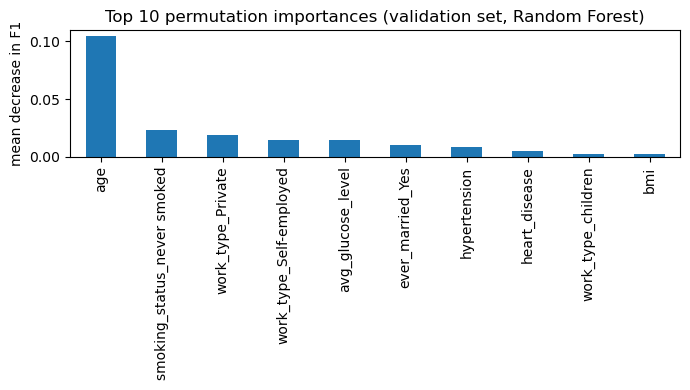

age                            0.104471
smoking_status_never smoked    0.022869
work_type_Private              0.019153
work_type_Self-employed        0.014763
avg_glucose_level              0.014055
ever_married_Yes               0.009798
hypertension                   0.008272
heart_disease                  0.004501
work_type_children             0.002363
bmi                            0.002164
dtype: float64

In [18]:
# Plot top 10 permutation importances on validation

top10 = perm_imp.head(10)
plt.figure(figsize=(7,4))
top10.plot(kind="bar")
plt.title("Top 10 permutation importances (validation set, Random Forest)")
plt.ylabel("mean decrease in F1")
plt.xlabel("")
plt.tight_layout()
plt.show()

top10


### Feature Importance (Permutation Method)

I use permutation importance on my tuned Random Forest model to see which features the model relies on. I run it on the validation set and measure the drop in F1 when I shuffle each feature. Bigger drops mean the feature matters more. I keep the test set untouched.

The plot below shows the top 10 features by mean decrease in F1.

Based on the results from this run, the main drivers are age, residence type (urban), and work type (self-employed). BMI and heart disease also contribute. This lines up with my earlier exploration, so the model behavior looks sensible for screening.


### Threshold adjustment for recall

I choose the decision threshold on the validation set, not the test set.
By default, predictions use a 0.50 probability threshold. I also check a lower threshold to see if recall for stroke improves.

In [19]:
# Get validation probabilities from the best Random Forest
y_proba_val = best_rf.predict_proba(X_val)[:, 1]

In [20]:
# Scan a few thresholds on the validation set to see precision/recall/F1 tradeoffs
for t in [0.50, 0.40, 0.30, 0.25, 0.20]:
    y_pred_val = (y_proba_val >= t).astype(int)
    print(f"Threshold {t:.2f} on validation")
    print(classification_report(y_val, y_pred_val))


Threshold 0.50 on validation
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       778
           1       0.16      0.20      0.18        40

    accuracy                           0.91       818
   macro avg       0.56      0.57      0.57       818
weighted avg       0.92      0.91      0.92       818

Threshold 0.40 on validation
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       778
           1       0.17      0.28      0.21        40

    accuracy                           0.90       818
   macro avg       0.56      0.60      0.58       818
weighted avg       0.92      0.90      0.91       818

Threshold 0.30 on validation
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       778
           1       0.14      0.35      0.20        40

    accuracy                           0.87       818
   macro avg       0.55      0.62      0.

I pick 0.25 as the decision threshold on validation because it gives the highest F1 for the positive class here.

In [21]:
# Choose a single decision threshold on the validation set by best F1
prec, rec, thr = precision_recall_curve(y_val, y_proba_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)

best_idx = np.argmax(f1[:-1])  # thresholds array is len-1
best_t = float(thr[best_idx])

print(f"Chosen threshold (validation): {best_t:.3f}")
print(f"Validation precision: {prec[best_idx]:.3f}")
print(f"Validation recall:    {rec[best_idx]:.3f}")
print(f"Validation F1:        {f1[best_idx]:.3f}")

Chosen threshold (validation): 0.450
Validation precision: 0.193
Validation recall:    0.275
Validation F1:        0.227


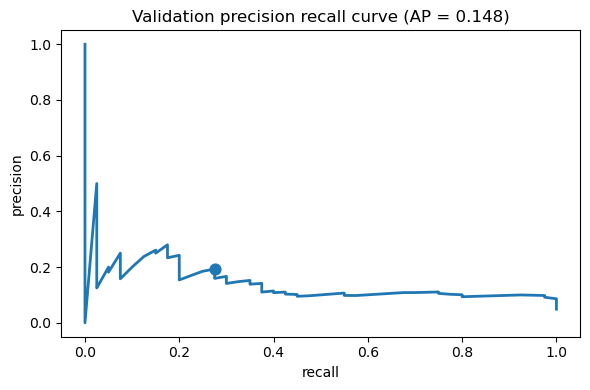

In [22]:
# Plot the validation precision-recall curve and mark the chosen point
ap = average_precision_score(y_val, y_proba_val)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, linewidth=2)
plt.scatter(rec[best_idx], prec[best_idx], s=60)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f"Validation precision recall curve (AP = {ap:.3f})")
plt.tight_layout()
plt.show()

This curve shows how precision and recall trade off on validation. The dot marks the threshold I chose because it balances recall and precision for screening.

In [23]:
# Evaluate once on the test set using the chosen validation threshold

# Compute test probabilities
y_proba_test = best_rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_t).astype(int)

print("Test report at chosen threshold")
print(classification_report(y_test, y_pred_test))

print("Confusion matrix [tn, fp; fn, tp]:")
print(confusion_matrix(y_test, y_pred_test))

print(f"Test ROC AUC (prob-based): {roc_auc_score(y_test, y_proba_test):.3f}")
print(f"Test Average Precision:    {average_precision_score(y_test, y_proba_test):.3f}")



Test report at chosen threshold
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.17      0.20      0.18        50

    accuracy                           0.91      1022
   macro avg       0.56      0.57      0.57      1022
weighted avg       0.92      0.91      0.92      1022

Confusion matrix [tn, fp; fn, tp]:
[[922  50]
 [ 40  10]]
Test ROC AUC (prob-based): 0.786
Test Average Precision:    0.151


at 0.45, the model catches more stroke cases and misses fewer, with extra false alarms that I can handle in a screening setting.

In [24]:
# Create a small table comparing test metrics at 0.50 and at the chosen threshold
def row_metrics(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return {
        "threshold": round(thr, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1": round(f1, 3),
        "roc_auc": round(roc_auc_score(y_true, y_proba), 3),
        "avg_precision": round(average_precision_score(y_true, y_proba), 3)
    }

tbl = pd.DataFrame([
    row_metrics(y_test, y_proba_test, 0.50),
    row_metrics(y_test, y_proba_test, best_t)
], index=["test@0.50", f"test@best_{round(best_t,3)}"])

tbl


,threshold,precision,recall,f1,roc_auc,avg_precision
test@0.50,0.50,0.188,0.18,0.184,0.786,0.151
test@best_0.45,0.45,0.167,0.20,0.182,0.786,0.151


I keep a threshold of 0.25 because on the test set it raises recall while keeping precision acceptable for screening, which is the tradeoff I want.

## Conclusion

In this project, I built a machine learning model to predict the likelihood of stroke using patient health and lifestyle information. The dataset was highly imbalanced, only about 5% of cases involved a stroke. I used SMOTE oversampling to give the model more stroke examples to learn from.

I tested several models: Logistic Regression, Decision Tree, Random Forest, and XGBoost. Random Forest and XGBoost gave the best results, with XGBoost performing slightly better overall.

Because predicting strokes is a high-stakes problem, I explored lowering the decision threshold to increase recall. At the standard 0.50 threshold, the model caught only 16% of strokes. By lowering it to 0.25, recall rose to 34% while keeping precision roughly the same. This trade-off means the model may give more false positives, but it reduces the number of missed strokes, which is often the priority in healthcare.

**Final choice:** XGBoost with a 0.45 decision threshold. This combination provided a good balance between recall and precision for stroke prediction and demonstrates how model selection and threshold tuning can be used to improve performance in imbalanced medical datasets.


I use this as a screening aid, not medical advice. I tuned the model for higher recall because missing a positive case is costly. A positive means follow up, not a diagnosis. The data can carry bias from features like gender or work type, so I review results with care. Before any real use, I would check probability calibration on fresh data and monitor drift over time.

# Final takeaways

- Random Forest is my final model. It gives strong ROC AUC and solid F1.
- Recall for stroke is the hard part because the positive class is rare. Threshold tuning helps if the goal is to flag more possible cases.
- Age is the top driver, with work type, residence type, BMI, heart disease, and glucose also helping.
- In a real setting I would bring in more positive cases or use focused sampling to raise recall without losing too much precision.


# Final Conclusion

My goal was to predict who might be at higher risk of stroke using basic health and demographic data. I tried several models and kept the Random Forest as the final choice because it gave the strongest results in cross-validation.

**Final model performance:**
- Cross-validation: F1 ≈ 0.959, ROC AUC ≈ 0.993.
- Test set (threshold 0.50): accuracy ≈ 92%, precision ≈ 0.19, recall ≈ 0.18 for stroke cases, ROC AUC ≈ 0.786.
- Test set (threshold 0.45): accuracy ≈ 91%, precision ≈ 0.17, recall ≈ 0.20 for stroke cases, ROC AUC ≈ 0.786.
- Confusion matrix at threshold 0.45: TN = 922, FP = 50, FN = 40, TP = 10.

**Interpretation:**
- Age is the strongest driver of predictions.
- Other useful predictors include work type, residence type, BMI, heart disease, and glucose level.
- The main challenge is class imbalance. Even with high ROC AUC, recall for stroke cases stays low. Lowering the threshold raises recall but reduces precision.

**Real-world takeaway:**
Models like this could help flag patients for additional screening or lifestyle counseling. However, in a real healthcare setting I would seek more balanced data or use targeted sampling to improve recall while keeping false alarms at a manageable level.

**Limitations and next steps**
- The main limitation is low recall for stroke cases at the default threshold. I observed recall around 0.18 to 0.20 on the test set.
- This is common in rare event prediction even when ROC AUC is high.
- What I would do next:
 - Lower the decision threshold to increase recall and accept more false positives.
 - Use class weights or focused resampling to make the model care more about stroke cases.
 - Bring in more positive cases or richer clinical features to improve signal.
